# Fine-Tuning on Recorded Data

In [112]:
# Imports
import numpy as np
import pickle
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras

import kerascnn2c
from pathlib import Path
import copy


In [113]:
def fixed_point_conversion(x: np.array, fixed_point: int):
  x /= 2**fixed_point
  return x

## Read Data

In [114]:
data_dir = '../../data/fine-tuning/fine-tune.pkl'

with open(data_dir, 'rb') as file:
    data = pickle.load(file)
file.close()

x = data['x']
y = data['y']

permutation = np.random.permutation(len(x))
x = x[permutation]
y = y[permutation]

min_int16 = fixed_point_conversion(-(2**15), 9)
max_int16 = fixed_point_conversion((2**15)-1, 9)

scaler = MinMaxScaler(feature_range=(min_int16, max_int16))

x = np.array([scaler.fit_transform(np.array(i).reshape((16000,1))) for i in x])

print(f'X shape: {x.shape}')
print(f'Y shape: {y.shape}')


X shape: (244, 16000, 1)
Y shape: (244, 5)


In [115]:
# splitting into training and validation data
train_split = int(0.8*len(x))

x_train, x_val = x[:train_split,:], x[train_split:,:]
y_train, y_val = y[:train_split,:], y[train_split:,:]

print(f'X train: {x_train.shape}')
print(f'X val: {x_val.shape}')
print(f'y train: {y_train.shape}')
print(f'y val: {y_val.shape}')

X train: (195, 16000, 1)
X val: (49, 16000, 1)
y train: (195, 5)
y val: (49, 5)


In [116]:
# Available devices
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print('Name of Devices: ', tf.config.list_physical_devices())

Num GPUs Available:  1
Name of Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [117]:
# Create a basic model instance
checkpoint_path = '../models/test/pre-trained'


model = keras.models.load_model(checkpoint_path)
model.summary

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x31ae1bc10>>

In [118]:
# Training model with GPU
with tf.device('/gpu:0'):
  history = model.fit(x_train, y_train, epochs=1, batch_size=1, validation_data=(x_val, y_val))

# model.save('../models/checkpoints-v2/fine-tuned')

  1/195 [..............................] - ETA: 1:04 - loss: 0.0000e+00 - categorical_accuracy: 1.0000

2023-04-30 13:10:08.738553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


194/195 [============================>.] - ETA: 0s - loss: 17.9532 - categorical_accuracy: 0.2938

2023-04-30 13:10:10.786847: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


195/195 [==============================] - 3s 12ms/step - loss: 17.9945 - categorical_accuracy: 0.2923 - val_loss: 24.3469 - val_categorical_accuracy: 0.3265


In [119]:
with tf.device('/gpu:0'):
    model.evaluate(x_val, y_val, verbose=2)
    pred_test = model.predict(x_val)
    print(tf.math.confusion_matrix(y_val.argmax(axis=1), pred_test.argmax(axis=1)))

2/2 - 0s - loss: 24.3469 - categorical_accuracy: 0.3265 - 148ms/epoch - 74ms/step
2/2 [==============================] - 0s 15ms/step
tf.Tensor(
[[ 0  0  0  0 14]
 [ 0  0  0  0  0]
 [ 0  0  0  0 18]
 [ 0  0  0  0  0]
 [ 1  0  0  0 16]], shape=(5, 5), dtype=int32)


2023-04-30 13:10:11.260339: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-30 13:10:11.393619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 6ms/step


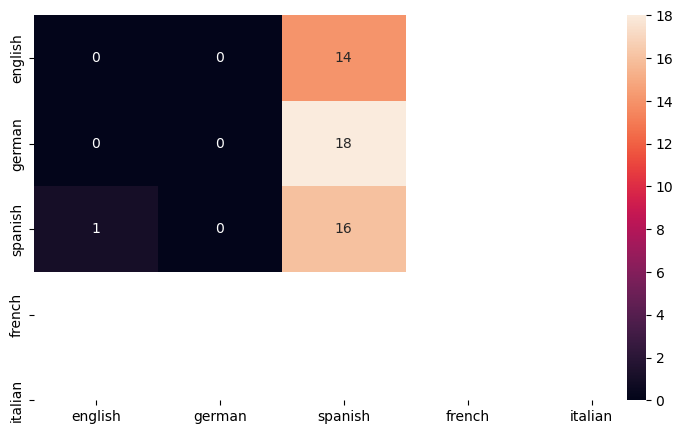

In [120]:
# Confusion matrix:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

CLASSES = ['english', 'german', 'spanish', 'french', 'italian']

preds = model.predict(x_val)
y_classes = preds.argmax(axis=-1)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true = y_val.argmax(axis=-1), y_pred = y_classes)

df_cm = pd.DataFrame(cm)
plt.figure(figsize = (9,5))
sn.heatmap(df_cm, annot=True, fmt = '.3g', xticklabels=CLASSES, yticklabels=CLASSES)
plt.show()

In [121]:
model.save('./keras2c/lab_gsc_no_globalavg.h5')

# remove softmax
model = tf.keras.Model(model.input, model.layers[-2].output, name=model.name)

In [122]:
FIXED_POINT=9
res = kerascnn2c.Converter(output_path=Path('keras2c/gsc_output_fixed'),
                           fixed_point=FIXED_POINT, # Number of bits for the fractional part, Q7.9 format
                           number_type='int16_t', # Data type for weights/activations (16 bits quantization)
                           long_number_type='int32_t', # Data type for intermediate results
                           number_min=-(2**15), # Minimum value for 16-bit signed integers
                           number_max=(2**15)-1 # Maximum value for 16-bit signed integers
                          ).convert_model(copy.deepcopy(model))
with open('keras2c/gsc_model_fixed.h', 'w') as f:
    f.write(res)

INFO:tensorflow:Assets written to: ram://f1c45610-8e04-4652-9bea-3576a8f2db29/assets


INFO:tensorflow:Assets written to: ram://f1c45610-8e04-4652-9bea-3576a8f2db29/assets
